# Semantic Segmentation of Aeriel Imagery from Hurricane Harvey

The actual project work was a largely iterative process and trial of different model and techniques. The below set of code is the final developed methodology and training.



In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch

from torch.utils.data import DataLoader, random_split #Load Data in dataloader and random split

import glob #For reading and storing path directories

from preprocessing import augment_images, patch_dataset #Import functions and classes defined in the attached preprocessing.py file

## Data Import and Visualization

In [2]:
df_train = pd.read_csv('Data/train.csv')
df_train.head()

,Unnamed: 0,image-id,image:01,date:01,type,geometry,label
0,0,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,121 1709 105 1842 97 2070 383 2094 369 2580 10...,Property Roof
1,1,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,2716 2336 2877 2527 2939 2504 2953 2460 2927 2...,Vehicle
2,2,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,2809 2171 3002 2419 3099 2363 3044 2287 2962 2...,Vehicle
3,3,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,3399 2922 3468 2918 3628 2952 3696 2894 3902 2...,Property Roof
4,4,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,2826 1633 3063 1909 3136 1872 3245 1772 3047 1...,Secondary Structure


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22419 entries, 0 to 22418
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  22419 non-null  int64 
 1   image-id    22419 non-null  object
 2   image:01    22419 non-null  object
 3   date:01     22419 non-null  object
 4   type        22419 non-null  object
 5   geometry    22419 non-null  object
 6   label       22419 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.2+ MB


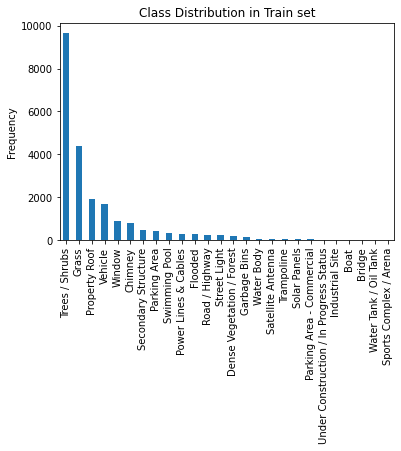

In [4]:
#Train Data Label Distribution 
df_train.label.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.title('Class Distribution in Train set')
plt.show()

## Data Pre-processing

Images shall all augmented at random using brightening/darkening, horizontal/vertical flips and rotation
techniques. Since the images are quite large, images shall be splits into smaller patches so that the model can capture model details. These shall be stored in a dataset object which would slow training since the augmented images are only split into a patch when called in the object. However, it saves the need to save the patches locally on the drive.

In [5]:
#Create a new Training Images based on conditions set in augment_image function found in preprocessing.py
path = 'Data/'
train_img_path, train_msk_path = augment_images(image_path = path + 'sample_images/',
                                                mask_path = path + 'sample_masks/', parent_dir = path)

In [6]:
#Create Train Dataset object using patch_dataset class defined in preprocessing.py
train_dataset = patch_dataset(sorted(glob.glob(train_img_path + '/*')),
                              sorted(glob.glob(train_msk_path+'/*')),patch_size_x = 1333, patch_size_y = 1500)

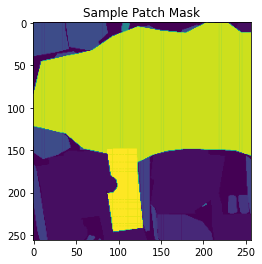

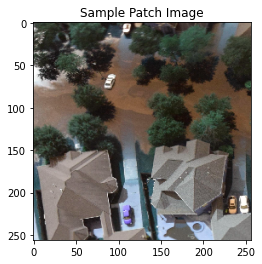

In [9]:
#Example mask patch
rand_idx = np.random.randint(len(glob.glob(train_img_path + '/*')) - 1, dtype=int)
rand_patch_idx = np.random.randint(train_dataset[0][1].shape[0] - 1, dtype=int)
plt.figure()
plt.imshow(train_dataset[rand_idx][1][rand_patch_idx])
plt.title('Sample Patch Mask')
plt.show()
plt.figure()

plt.imshow(train_dataset[rand_idx][0][rand_patch_idx].permute(1,2,0).detach().numpy())
plt.title('Sample Patch Image')
plt.show()

## Model Training

The baseline architecture for this projects is a U-NET model who's architecture has been built has been built from scratch and can be found in the old files in the repository. For the final model trials, pre-trained U-NET and PSP-NET were used to boost performance.

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp # semantic segmentation library with pre-trained segmentation models
from torch.optim import lr_scheduler #learning rate schedules that decays learning rate during training

In [ ]:
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_set, test_set = random_split(train_dataset, [train_size, test_size])

In [ ]:
#small batch size chosen since each entry in a batch contains 6 patches. So each batch will contained 60 images to train on 
train_dataloader = DataLoader(train_set, batch_size=10, shuffle=True) 
val_dataloader = DataLoader(test_set, batch_size=10, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

Device used: cpu


In [ ]:
from models import train_smp_model #function to train unet models from the models.py
from plot_utils import plot_losses #function to plot losses from plot_utils.py

### U-NET Training

In [ ]:
model_Unet = smp.Unet(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet',
    in_channels = 3, 
    classes = 27, 
    decoder_channels=(512, 256, 128, 64, 32),
    activation = None, 
).to(device)

In [ ]:
lr = 0.001 #initial learning rate 
optimizer = torch.optim.Adam(model_Unet.parameters(), lr = lr)
epochs = 30
lr_scheduler = lr_scheduler.PolynomialLR(optimizer,total_iters= epochs, power=0.9) #schedule to decay initial learning rate

In [ ]:
from models import train_smp_model #function created to train U-Net
from plot_utils import plot_losses #function creates to plot training losses

In [ ]:
model_Unet,total_train_losses, total_train_accuracy, total_train_f1, total_val_losses, total_val_accuracy, total_val_f1 = train_smp_model(model_Unet, 
                                                                                                                                     optimizer, 
                                                                                                                                     epochs, 
                                                                                                                                     train_dataloader, 
                                                                                                                                     val_dataloader, 
                                                                                                                                     lr_scheduler, 
                                                                                                                                     device,
                                                                                                                                     model_name = 'Unet')

100%|██████████| 24/24 [08:38<00:00, 21.62s/it]


TRAIN       Epoch: 1 | Epoch metrics | loss: 2.3886, f1: 0.209, accuracy: 0.374


100%|██████████| 6/6 [02:21<00:00, 23.56s/it]


VAL       Epoch: 1 | Epoch metrics | loss: 2.5305, f1: 0.192, accuracy: 0.402


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 2 | Epoch metrics | loss: 1.4795, f1: 0.320, accuracy: 0.585


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 2 | Epoch metrics | loss: 2.0386, f1: 0.294, accuracy: 0.551


100%|██████████| 24/24 [01:46<00:00,  4.46s/it]


TRAIN       Epoch: 3 | Epoch metrics | loss: 1.2536, f1: 0.338, accuracy: 0.619


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 3 | Epoch metrics | loss: 1.3336, f1: 0.319, accuracy: 0.596


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 4 | Epoch metrics | loss: 1.1915, f1: 0.335, accuracy: 0.638


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 4 | Epoch metrics | loss: 1.3983, f1: 0.307, accuracy: 0.598


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 5 | Epoch metrics | loss: 1.1188, f1: 0.353, accuracy: 0.651


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 5 | Epoch metrics | loss: 1.2107, f1: 0.340, accuracy: 0.629


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 6 | Epoch metrics | loss: 1.1076, f1: 0.355, accuracy: 0.656


100%|██████████| 6/6 [00:26<00:00,  4.42s/it]


VAL       Epoch: 6 | Epoch metrics | loss: 1.0899, f1: 0.366, accuracy: 0.671


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 7 | Epoch metrics | loss: 1.0656, f1: 0.362, accuracy: 0.666


100%|██████████| 6/6 [00:26<00:00,  4.37s/it]


VAL       Epoch: 7 | Epoch metrics | loss: 1.1763, f1: 0.345, accuracy: 0.651


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 8 | Epoch metrics | loss: 1.0505, f1: 0.364, accuracy: 0.670


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 8 | Epoch metrics | loss: 1.0849, f1: 0.368, accuracy: 0.692


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 9 | Epoch metrics | loss: 0.9727, f1: 0.374, accuracy: 0.700


100%|██████████| 6/6 [00:26<00:00,  4.38s/it]


VAL       Epoch: 9 | Epoch metrics | loss: 1.0426, f1: 0.364, accuracy: 0.688


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 10 | Epoch metrics | loss: 0.9595, f1: 0.370, accuracy: 0.702


100%|██████████| 6/6 [00:26<00:00,  4.38s/it]


VAL       Epoch: 10 | Epoch metrics | loss: 1.1687, f1: 0.346, accuracy: 0.680


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 11 | Epoch metrics | loss: 0.9461, f1: 0.372, accuracy: 0.695


100%|██████████| 6/6 [00:26<00:00,  4.37s/it]


VAL       Epoch: 11 | Epoch metrics | loss: 1.0306, f1: 0.366, accuracy: 0.685


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 12 | Epoch metrics | loss: 0.9427, f1: 0.378, accuracy: 0.706


100%|██████████| 6/6 [00:26<00:00,  4.38s/it]


VAL       Epoch: 12 | Epoch metrics | loss: 1.0991, f1: 0.360, accuracy: 0.672


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 13 | Epoch metrics | loss: 0.9204, f1: 0.380, accuracy: 0.714


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 13 | Epoch metrics | loss: 1.0319, f1: 0.373, accuracy: 0.699


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 14 | Epoch metrics | loss: 0.9055, f1: 0.382, accuracy: 0.718


100%|██████████| 6/6 [00:26<00:00,  4.38s/it]


VAL       Epoch: 14 | Epoch metrics | loss: 0.9426, f1: 0.367, accuracy: 0.717


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 15 | Epoch metrics | loss: 0.8558, f1: 0.385, accuracy: 0.731


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 15 | Epoch metrics | loss: 0.9677, f1: 0.371, accuracy: 0.711


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 16 | Epoch metrics | loss: 0.8143, f1: 0.390, accuracy: 0.746


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 16 | Epoch metrics | loss: 0.9895, f1: 0.376, accuracy: 0.712


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 17 | Epoch metrics | loss: 0.8195, f1: 0.389, accuracy: 0.748


100%|██████████| 6/6 [00:26<00:00,  4.41s/it]


VAL       Epoch: 17 | Epoch metrics | loss: 0.9298, f1: 0.367, accuracy: 0.725


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 18 | Epoch metrics | loss: 0.7880, f1: 0.396, accuracy: 0.758


100%|██████████| 6/6 [00:26<00:00,  4.38s/it]


VAL       Epoch: 18 | Epoch metrics | loss: 0.9633, f1: 0.380, accuracy: 0.723


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 19 | Epoch metrics | loss: 0.7898, f1: 0.395, accuracy: 0.754


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 19 | Epoch metrics | loss: 0.9894, f1: 0.361, accuracy: 0.705


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 20 | Epoch metrics | loss: 0.7531, f1: 0.401, accuracy: 0.765


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 20 | Epoch metrics | loss: 0.9773, f1: 0.359, accuracy: 0.701


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 21 | Epoch metrics | loss: 0.7235, f1: 0.403, accuracy: 0.779


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 21 | Epoch metrics | loss: 0.9819, f1: 0.373, accuracy: 0.699


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 22 | Epoch metrics | loss: 0.6899, f1: 0.409, accuracy: 0.791


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 22 | Epoch metrics | loss: 0.8561, f1: 0.390, accuracy: 0.749


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 23 | Epoch metrics | loss: 0.6608, f1: 0.412, accuracy: 0.803


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 23 | Epoch metrics | loss: 0.8517, f1: 0.388, accuracy: 0.747


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 24 | Epoch metrics | loss: 0.6432, f1: 0.417, accuracy: 0.806


100%|██████████| 6/6 [00:26<00:00,  4.42s/it]


VAL       Epoch: 24 | Epoch metrics | loss: 0.9103, f1: 0.385, accuracy: 0.725


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 25 | Epoch metrics | loss: 0.6389, f1: 0.416, accuracy: 0.811


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 25 | Epoch metrics | loss: 0.8720, f1: 0.393, accuracy: 0.754


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 26 | Epoch metrics | loss: 0.6208, f1: 0.420, accuracy: 0.818


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 26 | Epoch metrics | loss: 1.1135, f1: 0.387, accuracy: 0.736


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 27 | Epoch metrics | loss: 0.5987, f1: 0.422, accuracy: 0.824


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 27 | Epoch metrics | loss: 0.8872, f1: 0.388, accuracy: 0.743


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 28 | Epoch metrics | loss: 0.5694, f1: 0.427, accuracy: 0.834


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 28 | Epoch metrics | loss: 0.8422, f1: 0.391, accuracy: 0.748


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 29 | Epoch metrics | loss: 0.5450, f1: 0.432, accuracy: 0.843


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 29 | Epoch metrics | loss: 0.8239, f1: 0.395, accuracy: 0.760


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 30 | Epoch metrics | loss: 0.5062, f1: 0.437, accuracy: 0.855


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]

VAL       Epoch: 30 | Epoch metrics | loss: 0.8563, f1: 0.393, accuracy: 0.753


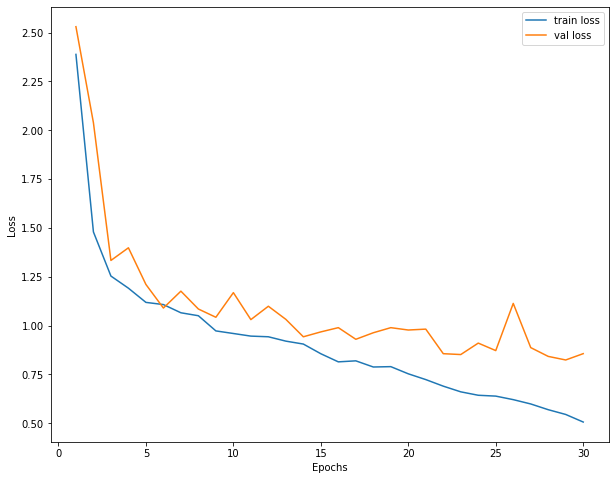

In [ ]:
plot_losses(total_train_losses, total_val_losses)

### PSP-NET Training

In [ ]:
##PSP-net initialized with 101-deep residual network encoder, pre-trained imagenet weights, 3 input channels
#27 output channels
model_PSP = smp.PSPNet(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 27, 
    activation = None,
).to(device)

In [ ]:
min_val_f1 = 0.350 #baseline

In [ ]:
lr = 0.001 #initial learning rate 
optimizer = torch.optim.Adam(model_PSP.parameters(), lr = lr)
epochs = 30
lr_scheduler = lr_scheduler.PolynomialLR(optimizer,total_iters= epochs, power=0.9) #schedule to decay initial learning rate

In [ ]:
from models import train_smp_model #function created to train U-Net
from plot_utils import plot_losses #function creates to plot training losses

In [ ]:
model_PSP,total_train_losses, total_train_accuracy, total_train_f1, total_val_losses, total_val_accuracy, total_val_f1 = train_smp_model(model_PSP, 
                                                                                                                                     optimizer, 
                                                                                                                                     epochs, 
                                                                                                                                     train_dataloader, 
                                                                                                                                     val_dataloader, 
                                                                                                                                     lr_scheduler, 
                                                                                                                                     device,
                                                                                                                                     model_name = 'PSP')

  0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 45/45 [29:20<00:00, 39.13s/it]


TRAIN       Epoch: 1 | Epoch metrics | loss: 1.5943, f1: 0.247, accuracy: 0.535


100%|██████████| 12/12 [07:39<00:00, 38.33s/it]


VAL       Epoch: 1 | Epoch metrics | loss: 1.3306, f1: 0.289, accuracy: 0.569


100%|██████████| 45/45 [05:13<00:00,  6.97s/it]


TRAIN       Epoch: 2 | Epoch metrics | loss: 1.2586, f1: 0.296, accuracy: 0.610


100%|██████████| 12/12 [01:20<00:00,  6.71s/it]


VAL       Epoch: 2 | Epoch metrics | loss: 1.2519, f1: 0.298, accuracy: 0.601


100%|██████████| 45/45 [05:14<00:00,  6.99s/it]


TRAIN       Epoch: 3 | Epoch metrics | loss: 1.1027, f1: 0.320, accuracy: 0.650


100%|██████████| 12/12 [01:20<00:00,  6.75s/it]


VAL       Epoch: 3 | Epoch metrics | loss: 1.2514, f1: 0.320, accuracy: 0.632


100%|██████████| 45/45 [05:18<00:00,  7.07s/it]


TRAIN       Epoch: 4 | Epoch metrics | loss: 1.0803, f1: 0.322, accuracy: 0.655


100%|██████████| 12/12 [01:21<00:00,  6.76s/it]


VAL       Epoch: 4 | Epoch metrics | loss: 1.0352, f1: 0.350, accuracy: 0.671


100%|██████████| 45/45 [05:15<00:00,  7.01s/it]


TRAIN       Epoch: 5 | Epoch metrics | loss: 0.9790, f1: 0.333, accuracy: 0.690


100%|██████████| 12/12 [01:22<00:00,  6.87s/it]


VAL       Epoch: 5 | Epoch metrics | loss: 1.3263, f1: 0.342, accuracy: 0.646


100%|██████████| 45/45 [05:19<00:00,  7.09s/it]


TRAIN       Epoch: 6 | Epoch metrics | loss: 0.9429, f1: 0.342, accuracy: 0.697


100%|██████████| 12/12 [01:22<00:00,  6.89s/it]


VAL       Epoch: 6 | Epoch metrics | loss: 1.0557, f1: 0.358, accuracy: 0.682


100%|██████████| 45/45 [05:17<00:00,  7.05s/it]


TRAIN       Epoch: 7 | Epoch metrics | loss: 0.8893, f1: 0.346, accuracy: 0.711


100%|██████████| 12/12 [01:22<00:00,  6.87s/it]


VAL       Epoch: 7 | Epoch metrics | loss: 1.0003, f1: 0.349, accuracy: 0.664


100%|██████████| 45/45 [05:17<00:00,  7.05s/it]


TRAIN       Epoch: 8 | Epoch metrics | loss: 0.8410, f1: 0.350, accuracy: 0.722


100%|██████████| 12/12 [01:22<00:00,  6.90s/it]


VAL       Epoch: 8 | Epoch metrics | loss: 1.0283, f1: 0.353, accuracy: 0.688


100%|██████████| 45/45 [05:18<00:00,  7.09s/it]


TRAIN       Epoch: 9 | Epoch metrics | loss: 0.8219, f1: 0.355, accuracy: 0.729


100%|██████████| 12/12 [01:21<00:00,  6.81s/it]


VAL       Epoch: 9 | Epoch metrics | loss: 0.8332, f1: 0.362, accuracy: 0.724


100%|██████████| 45/45 [05:16<00:00,  7.03s/it]


TRAIN       Epoch: 10 | Epoch metrics | loss: 0.7859, f1: 0.361, accuracy: 0.741


100%|██████████| 12/12 [01:21<00:00,  6.77s/it]


VAL       Epoch: 10 | Epoch metrics | loss: 0.9938, f1: 0.365, accuracy: 0.697


100%|██████████| 45/45 [05:12<00:00,  6.94s/it]


TRAIN       Epoch: 11 | Epoch metrics | loss: 0.7720, f1: 0.359, accuracy: 0.743


100%|██████████| 12/12 [01:22<00:00,  6.86s/it]


VAL       Epoch: 11 | Epoch metrics | loss: 0.9229, f1: 0.346, accuracy: 0.712


100%|██████████| 45/45 [05:19<00:00,  7.11s/it]


TRAIN       Epoch: 12 | Epoch metrics | loss: 0.7369, f1: 0.366, accuracy: 0.755


100%|██████████| 12/12 [01:22<00:00,  6.85s/it]


VAL       Epoch: 12 | Epoch metrics | loss: 0.7929, f1: 0.382, accuracy: 0.746


100%|██████████| 45/45 [05:18<00:00,  7.09s/it]


TRAIN       Epoch: 13 | Epoch metrics | loss: 0.7257, f1: 0.371, accuracy: 0.760


100%|██████████| 12/12 [01:22<00:00,  6.88s/it]


VAL       Epoch: 13 | Epoch metrics | loss: 0.8017, f1: 0.379, accuracy: 0.743


100%|██████████| 45/45 [05:18<00:00,  7.08s/it]


TRAIN       Epoch: 14 | Epoch metrics | loss: 0.6910, f1: 0.374, accuracy: 0.769


100%|██████████| 12/12 [01:22<00:00,  6.88s/it]


VAL       Epoch: 14 | Epoch metrics | loss: 0.7493, f1: 0.392, accuracy: 0.764


100%|██████████| 45/45 [05:17<00:00,  7.06s/it]


TRAIN       Epoch: 15 | Epoch metrics | loss: 0.6680, f1: 0.378, accuracy: 0.777


100%|██████████| 12/12 [01:22<00:00,  6.88s/it]


VAL       Epoch: 15 | Epoch metrics | loss: 0.7013, f1: 0.393, accuracy: 0.771


100%|██████████| 45/45 [05:15<00:00,  7.02s/it]


TRAIN       Epoch: 16 | Epoch metrics | loss: 0.6503, f1: 0.382, accuracy: 0.783


100%|██████████| 12/12 [01:21<00:00,  6.82s/it]


VAL       Epoch: 16 | Epoch metrics | loss: 0.7750, f1: 0.361, accuracy: 0.754


100%|██████████| 45/45 [05:19<00:00,  7.09s/it]


TRAIN       Epoch: 17 | Epoch metrics | loss: 0.6443, f1: 0.381, accuracy: 0.785


100%|██████████| 12/12 [01:22<00:00,  6.87s/it]


VAL       Epoch: 17 | Epoch metrics | loss: 0.7324, f1: 0.382, accuracy: 0.764


100%|██████████| 45/45 [05:19<00:00,  7.09s/it]


TRAIN       Epoch: 18 | Epoch metrics | loss: 0.6245, f1: 0.386, accuracy: 0.792


100%|██████████| 12/12 [01:21<00:00,  6.78s/it]


VAL       Epoch: 18 | Epoch metrics | loss: 0.7725, f1: 0.386, accuracy: 0.759


100%|██████████| 45/45 [05:18<00:00,  7.09s/it]


TRAIN       Epoch: 19 | Epoch metrics | loss: 0.6025, f1: 0.388, accuracy: 0.801


100%|██████████| 12/12 [01:22<00:00,  6.87s/it]


VAL       Epoch: 19 | Epoch metrics | loss: 0.6704, f1: 0.394, accuracy: 0.781


100%|██████████| 45/45 [05:17<00:00,  7.05s/it]


TRAIN       Epoch: 20 | Epoch metrics | loss: 0.5946, f1: 0.389, accuracy: 0.801


100%|██████████| 12/12 [01:22<00:00,  6.83s/it]


VAL       Epoch: 20 | Epoch metrics | loss: 0.6946, f1: 0.395, accuracy: 0.782


100%|██████████| 45/45 [05:18<00:00,  7.07s/it]


TRAIN       Epoch: 21 | Epoch metrics | loss: 0.5721, f1: 0.394, accuracy: 0.811


100%|██████████| 12/12 [01:22<00:00,  6.86s/it]


VAL       Epoch: 21 | Epoch metrics | loss: 0.6496, f1: 0.394, accuracy: 0.784


100%|██████████| 45/45 [05:19<00:00,  7.10s/it]


TRAIN       Epoch: 22 | Epoch metrics | loss: 0.5485, f1: 0.397, accuracy: 0.818


100%|██████████| 12/12 [01:22<00:00,  6.85s/it]


VAL       Epoch: 22 | Epoch metrics | loss: 0.6833, f1: 0.406, accuracy: 0.784


100%|██████████| 45/45 [05:18<00:00,  7.09s/it]


TRAIN       Epoch: 23 | Epoch metrics | loss: 0.5539, f1: 0.396, accuracy: 0.814


100%|██████████| 12/12 [01:22<00:00,  6.84s/it]


VAL       Epoch: 23 | Epoch metrics | loss: 0.6419, f1: 0.411, accuracy: 0.793


100%|██████████| 45/45 [05:17<00:00,  7.06s/it]


TRAIN       Epoch: 24 | Epoch metrics | loss: 0.5107, f1: 0.403, accuracy: 0.830


100%|██████████| 12/12 [01:22<00:00,  6.85s/it]


VAL       Epoch: 24 | Epoch metrics | loss: 0.6269, f1: 0.408, accuracy: 0.799


100%|██████████| 45/45 [05:19<00:00,  7.10s/it]


TRAIN       Epoch: 25 | Epoch metrics | loss: 0.4890, f1: 0.408, accuracy: 0.841


100%|██████████| 12/12 [01:22<00:00,  6.85s/it]


VAL       Epoch: 25 | Epoch metrics | loss: 0.6267, f1: 0.406, accuracy: 0.799


100%|██████████| 45/45 [05:19<00:00,  7.09s/it]


TRAIN       Epoch: 26 | Epoch metrics | loss: 0.4812, f1: 0.409, accuracy: 0.840


100%|██████████| 12/12 [01:20<00:00,  6.74s/it]


VAL       Epoch: 26 | Epoch metrics | loss: 0.6135, f1: 0.411, accuracy: 0.804


100%|██████████| 45/45 [05:16<00:00,  7.03s/it]


TRAIN       Epoch: 27 | Epoch metrics | loss: 0.4700, f1: 0.410, accuracy: 0.846


100%|██████████| 12/12 [01:21<00:00,  6.77s/it]


VAL       Epoch: 27 | Epoch metrics | loss: 0.5915, f1: 0.416, accuracy: 0.812


100%|██████████| 45/45 [05:17<00:00,  7.06s/it]


TRAIN       Epoch: 28 | Epoch metrics | loss: 0.4491, f1: 0.415, accuracy: 0.853


100%|██████████| 12/12 [01:22<00:00,  6.84s/it]


VAL       Epoch: 28 | Epoch metrics | loss: 0.6088, f1: 0.414, accuracy: 0.806


100%|██████████| 45/45 [05:20<00:00,  7.12s/it]


TRAIN       Epoch: 29 | Epoch metrics | loss: 0.4375, f1: 0.417, accuracy: 0.858


100%|██████████| 12/12 [01:22<00:00,  6.89s/it]


VAL       Epoch: 29 | Epoch metrics | loss: 0.5816, f1: 0.420, accuracy: 0.817


 22%|██▏       | 10/45 [01:10<04:03,  6.95s/it]

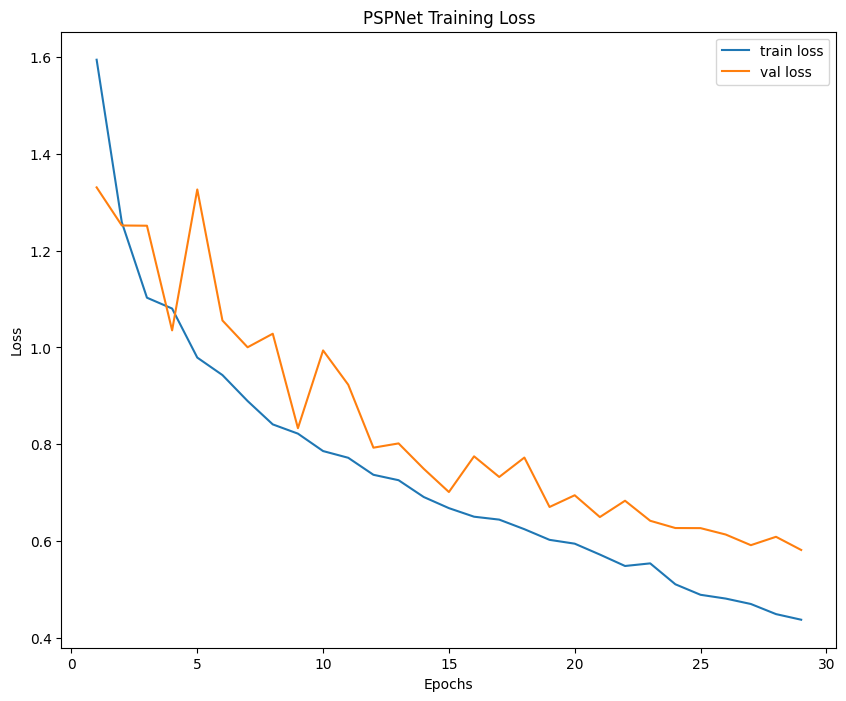

In [ ]:
plot_losses(total_train_losses, total_val_losses)

## Sample Model Outputs

Since PSP-Net outperformed the U-Net model, it was used as out final model for submissions. Below are some of the sample predictive outputs from the model on the validation set.

In [ ]:
from plot_utils import make_pred, plot_predictions #imported from plot_utils

In [ ]:
model_PSP = smp.PSPNet(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet', 
    classes = 27, 
    activation = None,
).to(device)

model_PSP.load_state_dict(torch.load(f'Models/PSP_pat_mid_29.pt',map_location = device))

In [ ]:
path_images = sorted(glob.glob('Data/sample_images/*')) #Path to validation set images
path_masks = sorted(glob.glob('Data/sample_masks/*')) #Path to training masks

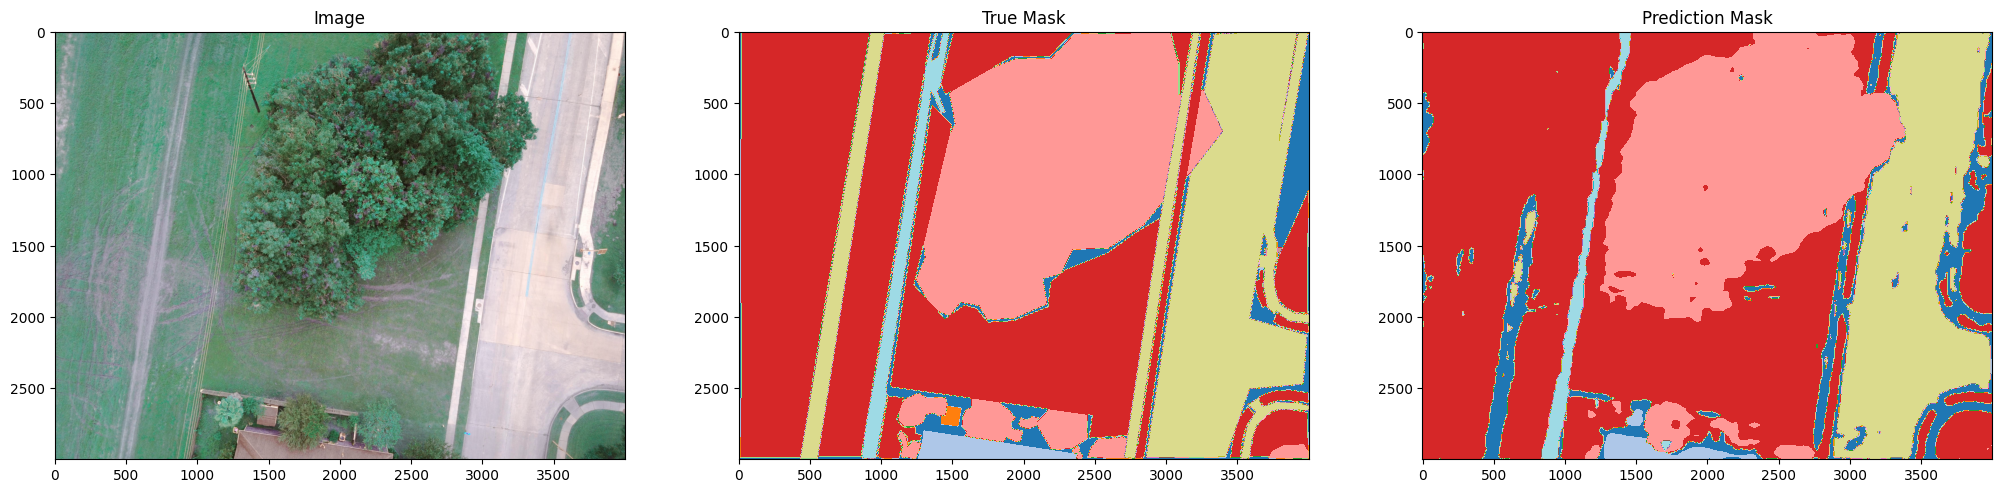

In [ ]:
image_num = 0
image, mask, pred = make_pred(model_PSP, path_images, path_masks, image_num)
plot_predictions(image, mask, pred)

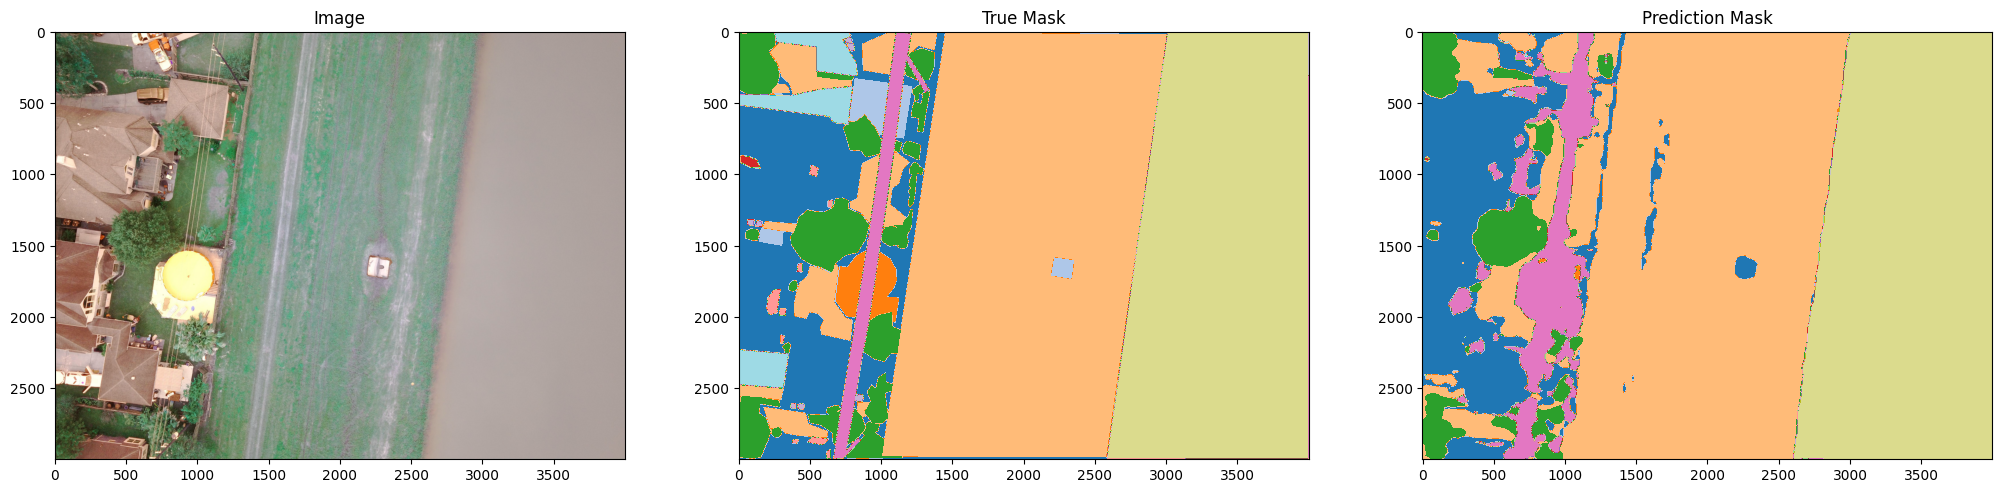

In [ ]:
image_num = 1
image, mask, pred = make_pred(model_PSP, path_images, path_masks, image_num)
plot_predictions(image, mask, pred)

It can be observed that the model struggles with the finer and small details in the observations. We can see however that the models successfully captures the important aspects and can detect that there is not flooding. Below is a similar example.

**Example with Flooding:**

Again, it can be observed that the model struggles with fine details. However, one interesting featur highlighted in this picture is there is also a flaw in the training set which could have impacted the training of the models. We can see that the true mask shows the entire area flooding when in reality there are trees exposed in the flooding area (captured by the prediction mask). Hence, the model outputted technically a correct prediction but one that is not accurate when compared to the mask. **It is therefore crucial for future work to first disect through the image set and to find masks that could negatively impact training.**

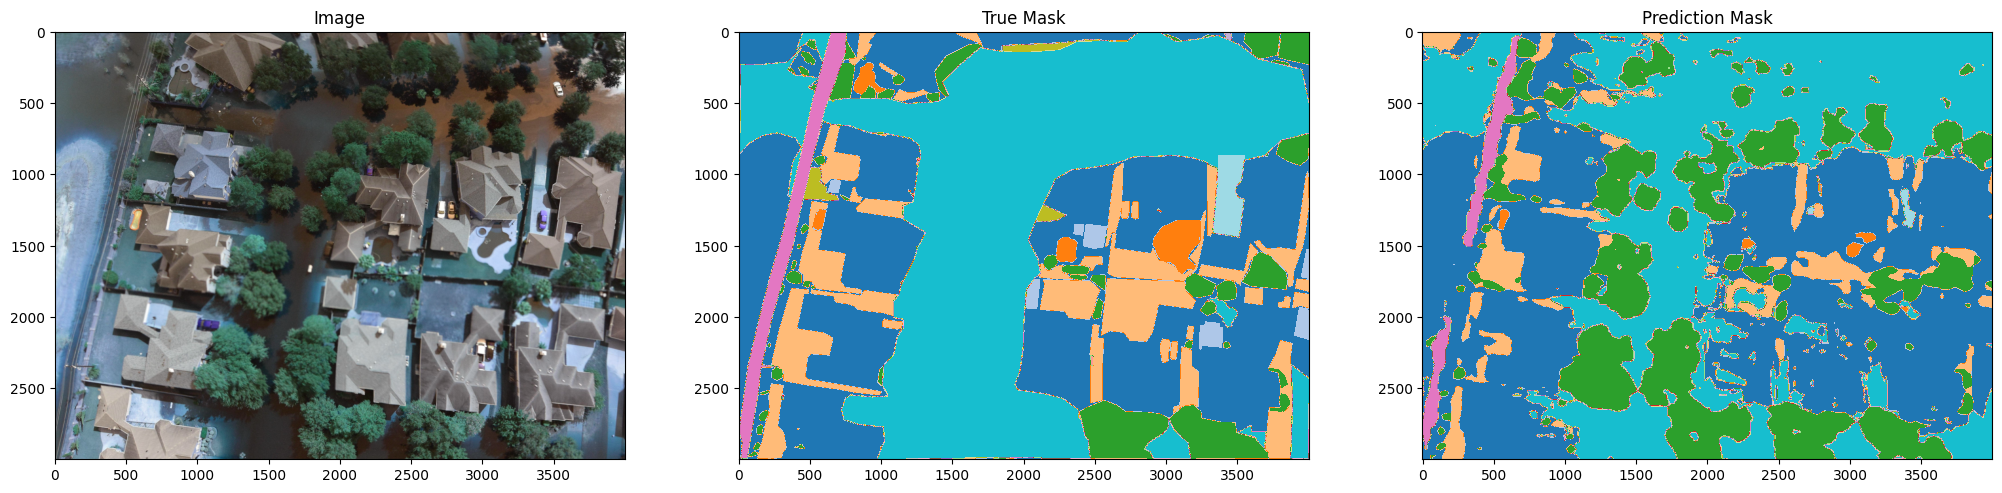

In [ ]:
image_num = 2
image, mask, pred = make_pred(model_PSP, path_images, path_masks, image_num)
plot_predictions(image, mask, pred)